### 모듈 가져오기

In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/07_PJT_final_01/01_clothes_classification

/content/drive/.shortcut-targets-by-id/1GjyX6hhmkv3p8CkgvOoSe14VWUuNEGQI/07_PJT_final_01/01_clothes_classification


In [4]:
img_size = 224
channel=3

In [9]:
train_datagen = ImageDataGenerator( 
        rescale=1./255,         # 픽셀 값을 0~1 범위로 변환
        # rotation_range=40,      # 40도까지 회전
        # width_shift_range=0.2,  # 20%까지 좌우 이동
        # height_shift_range=0.2, # 20%까지 상하 이동
        # shear_range=0.2,        # 20%까지 기울임
        # zoom_range=0.2,         # 20%까지 확대
        # horizontal_flip=True,   # 좌우 뒤집기
    )
train_generator = train_datagen.flow_from_directory(
    './dataset/Train',
    batch_size=100,      
    class_mode='categorical',
    target_size=(img_size, img_size)) 
valid_datagen = ImageDataGenerator(rescale=1./255) # 스케일링만 진행
valid_generator = valid_datagen.flow_from_directory(
    './dataset/Validation',
    batch_size=80,      
    class_mode='categorical',
    target_size=(img_size, img_size))
test_datagen = ImageDataGenerator(rescale=1./255) # 스케일링만 진행
test_generator = test_datagen.flow_from_directory(
    './dataset/data/test',
    batch_size=10,      
    class_mode='categorical', 
    target_size=(img_size, img_size),
    shuffle=False)

Found 32426 images belonging to 4 classes.
Found 7894 images belonging to 4 classes.
Found 10 images belonging to 4 classes.


In [10]:
print('train_generator class : ', train_generator.class_indices)
print('valid_generator class : ', valid_generator.class_indices)
print('test_generator class : ', test_generator.class_indices)

train_generator class :  {'bottoms': 0, 'one-piece': 1, 'outerwear': 2, 'tops': 3}
valid_generator class :  {'bottoms': 0, 'one-piece': 1, 'outerwear': 2, 'tops': 3}
test_generator class :  {'bottoms': 0, 'one-piece': 1, 'outerwear': 2, 'tops': 3}


## 모델 로드해서 테스트 진행

In [8]:
# model = load_model('./model/VGG16_01_11-17.2763.hdf5')

In [15]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/07_PJT_final_01/01_clothes_classification/model/VGG16_01_04-0.2891.hdf5')

In [16]:
model.evaluate(test_generator)

1/1 [==============================] - 1s 707ms/step - loss: 0.5111 - accuracy: 0.9000


[0.5110889673233032, 0.8999999761581421]

In [17]:
train_generator.class_indices

{'bottoms': 0, 'one-piece': 1, 'outerwear': 2, 'tops': 3}

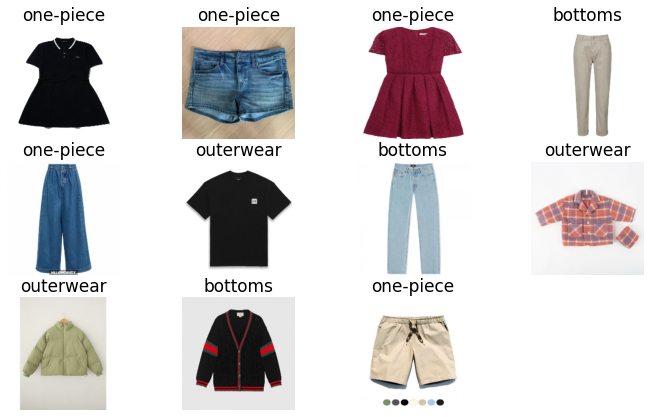

In [19]:
# 직접 찍은 음료 이미지로 예측 결과 확인

class_dict = {0:'bottoms', 1:'one-piece', 2:'outerwear', 3:'tops'}

fig = plt.figure(figsize=(12,12))
i=0
for img in glob.glob('./dataset/test3/*.jpg'):
    ax = plt.subplot(4,4,i+1) 
    test_img = cv2.imread(img)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    test_img = cv2.resize(test_img,(224,224))/255.0
    test_img_input = test_img.reshape((1,)+test_img.shape)
    pred = model.predict(test_img_input)
    pred_class = class_dict[np.argmax(pred, axis=1)[0]]
    ax.imshow(test_img)
    ax.axis('off')
    ax.set_title(f'{pred_class}',fontsize=17)
    i += 1
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.7, wspace=0.2, hspace=0.2)
plt.show()

## 모델 학습하기_VGG16
- 가중치 imagenet 사용
- 입력 데이터 사이즈 (224,224,3)
- 옵티마이저 adam, 학습률 0.0001
- train 데이터 배치사이즈 100
- 콜백함수 EarlyStopping, ModelCheckpoint
- 출력층
   * Dense(4, activation='softmax')

In [ ]:
# 파라미터 설정
classes = len(train_generator.class_indices)
epochs = 200
batch_size = 96

In [ ]:
vgg16 = tf.keras.applications.VGG16(weights='imagenet',
                                    include_top=False, 
                                    input_shape=(224, 224, 3))
vgg16.trainable = False # 학습으로 기존 가중치 갱신을 하지 않도록 지정

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 17,926,596
Trainable params: 3,211,908
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# 모델 환경설정
model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
model_name = './model/VGG16_01_{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=model_name, monitor='val_loss',save_best_only=True) # 성능이 개선될떄만 저장하도록
earlystopping = EarlyStopping(monitor='val_loss', patience=5) # 5번동안 성능개선이 없으면 학습 조기종료

### 모델 로드해서 이어 학습하기

In [ ]:
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=valid_generator, 
                    callbacks = [[earlystopping, checkpointer]]) 

Epoch 1/100
144/144 [==============================] - 11169s 78s/step - loss: 0.3178 - accuracy: 0.9058 - val_loss: 23.4296 - val_accuracy: 0.5125
Epoch 2/100
144/144 [==============================] - 564s 4s/step - loss: 0.1019 - accuracy: 0.9677 - val_loss: 22.9573 - val_accuracy: 0.5138
Epoch 3/100
144/144 [==============================] - 565s 4s/step - loss: 0.0843 - accuracy: 0.9721 - val_loss: 22.8135 - val_accuracy: 0.5163
Epoch 4/100
144/144 [==============================] - 572s 4s/step - loss: 0.0679 - accuracy: 0.9786 - val_loss: 22.4101 - val_accuracy: 0.5175
Epoch 5/100
144/144 [==============================] - 577s 4s/step - loss: 0.0710 - accuracy: 0.9765 - val_loss: 21.5050 - val_accuracy: 0.5174
Epoch 6/100
144/144 [==============================] - 576s 4s/step - loss: 0.0516 - accuracy: 0.9826 - val_loss: 21.2192 - val_accuracy: 0.5175
Epoch 7/100
144/144 [==============================] - 575s 4s/step - loss: 0.0589 - accuracy: 0.9797 - val_loss: 20.0674 - val

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/07_PJT_final_01/01_clothes_classification/model/VGG16_01_11-17.2763.hdf5')

OSError: ignored

In [ ]:
history2 = model.fit(train_generator,
                    epochs=100,
                    validation_data=valid_generator, 
                    callbacks = [[earlystopping, checkpointer]]) 

Epoch 1/100
325/325 [==============================] - 9921s 30s/step - loss: 0.4241 - accuracy: 0.8675 - val_loss: 0.2548 - val_accuracy: 0.9052
Epoch 2/100
325/325 [==============================] - 909s 3s/step - loss: 0.2700 - accuracy: 0.9007 - val_loss: 0.2306 - val_accuracy: 0.9197
Epoch 3/100
325/325 [==============================] - 916s 3s/step - loss: 0.2461 - accuracy: 0.9091 - val_loss: 0.2158 - val_accuracy: 0.9221
Epoch 4/100
325/325 [==============================] - 913s 3s/step - loss: 0.2299 - accuracy: 0.9144 - val_loss: 0.2052 - val_accuracy: 0.9241
Epoch 5/100
325/325 [==============================] - 913s 3s/step - loss: 0.2176 - accuracy: 0.9188 - val_loss: 0.2091 - val_accuracy: 0.9260
Epoch 6/100
325/325 [==============================] - 909s 3s/step - loss: 0.2029 - accuracy: 0.9270 - val_loss: 0.2083 - val_accuracy: 0.9293
Epoch 7/100
325/325 [==============================] - 929s 3s/step - loss: 0.1988 - accuracy: 0.9254 - val_loss: 0.2069 - val_accurac

In [ ]:
max(history2.history['accuracy'])

0.9441497325897217

In [ ]:
# 모델 저장
accuracy = round(max(history2.history['accuracy'])*100,0)
model.save(f'./model/VGG16_01_model_acc{accuracy}.h5') # 최종 모델 저장

In [ ]:
model.save(f'./model/VGG16_01_model_acc{accuracy}.h5') # 최종 모델 저장

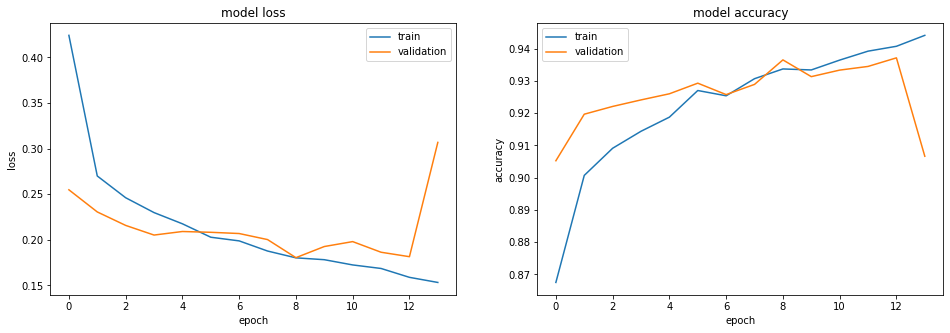

In [ ]:
plt.figure(figsize=(16,5))

# 만들어진 모델에 대해 train dataset과 validation dataset의 loss 를 그래프로 표현해 봅니다.
plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc=0)

# 만들어진 모델에 대해 train dataset과 validation dataset의 accuracy 를 그래프로 표현해 봅니다.
plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc=0)